In [1]:
"""
Epipolar Constraints for Self-Supervised Keypoint Detection

@author: Ganesh Sistu
"""
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

# Use any pair of images captured from the same camera with an unknown
# transformation matrix R/t (will be calculated as part of the essential matrix)

# K = np.array([[391.469, 0, 192],
#               [0, 342.976, 112],
#               [0, 0, 1]])

# img1 = cv2.imread('DSCF4668.JPG')
# img2 = cv2.imread('DSCF4669.JPG')
# # Resize images
# dim = (384, 224)
# image1 = cv2.resize(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), dim)
# image2 = cv2.resize(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), dim)

In [2]:
# Camera calibration and distortion parameters (OpenCV) kitti-odometry-grayscale dataset
# Camera.fx: 707.0912
# Camera.fy: 707.0912
# Camera.cx: 601.8873
# Camera.cy: 183.1104

# Camera.k1: 0.0
# Camera.k2: 0.0
# Camera.p1: 0.0
# Camera.p2: 0.0

K = np.array([[707.0912, 0, 601.8873],
              [0, 707.0912, 183.1104],
              [0, 0, 1]])

In [3]:
import glob
image_0_path_list = glob.glob('/spslam/kitti-odometry-gray/sequences/07/image_0/*')
image_0_path_list.sort()
print(image_0_path_list[1001])
# image_1_path_list = glob.glob('/spslam/kitti-odometry-gray/sequences/07/image_1/*')
# print(image_1_path_list[1001])


/spslam/kitti-odometry-gray/sequences/07/image_0/001001.png


In [4]:
img1 = cv2.imread(image_0_path_list[0], cv2.IMREAD_UNCHANGED)
img2 = cv2.imread(image_0_path_list[10], cv2.IMREAD_UNCHANGED)

img1_list = []
# img2_list = []

# Resize images
dim = (384, 224)
image1 = cv2.resize(img1, dim)
image2 = cv2.resize(img2, dim)

for i in range(len(image_0_path_list)):
    img1_list.append(cv2.imread(image_0_path_list[i], cv2.IMREAD_UNCHANGED))
#     img2_list.append(cv2.imread(image_1_path_list[i], cv2.IMREAD_UNCHANGED))

In [5]:
ground_data = np.loadtxt('/spslam/kitti-odometry-gray/poses/07.txt')

In [6]:
ground_data_0 = np.concatenate((ground_data[0],np.asarray([0,0,0,1]))).reshape(4,4)

In [7]:
print(ground_data_0)

[[1.000000e+00 1.197625e-11 1.704638e-10 5.551115e-17]
 [1.197625e-11 1.000000e+00 3.562503e-10 0.000000e+00]
 [1.704638e-10 3.562503e-10 1.000000e+00 2.220446e-16]
 [0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00]]


In [8]:
ground_data_10 = np.concatenate((ground_data[10],np.asarray([0,0,0,1]))).reshape(4,4)

In [9]:
print(ground_data_10)

[[ 9.912980e-01 -4.511767e-04 -1.316366e-01 -1.816057e-01]
 [-1.745510e-04  9.999887e-01 -4.741873e-03 -1.604515e-02]
 [ 1.316372e-01  4.723586e-03  9.912867e-01  1.251378e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]


# 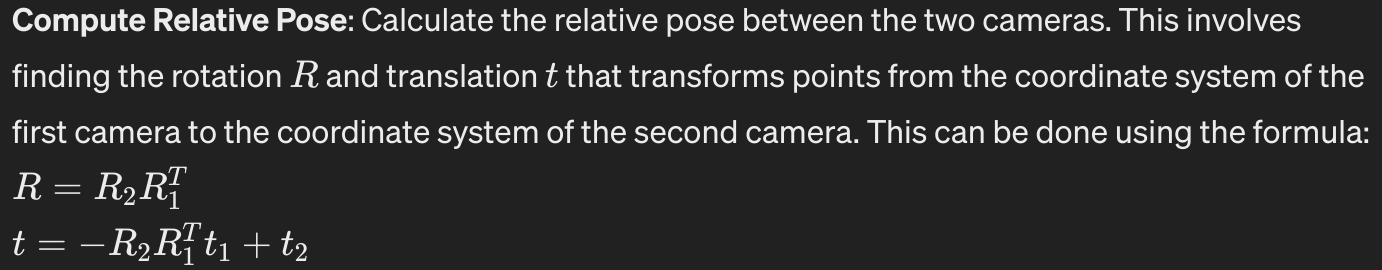

In [10]:
# R = ground_data_10[:-1,:-1].dot(np.transpose(ground_data_0[:-1,:-1]))
# t = -1*(ground_data_10[:-1,:-1].dot(np.transpose(ground_data_0[:-1,:-1]).dot(ground_data_0[:-1,-1])))+ground_data_10[:-1,-1]

# tx = np.array([[0, -t[2], t[1]],
#               [t[2], 0, -t[0]],
#               [-t[1], t[0], 0]])

# essential_matrix = np.dot(tx, R)
# essential_matrix

In [11]:
# Transformation of frame 10 relative to frame 0.
# frame0_frame10 = frame0_ref * ref_frame10 = (ref_frame0)^(-1) * ref_frame10
relative_pose = np.linalg.inv(ground_data_0).dot(ground_data_10)
relative_pose

array([[ 9.91298000e-01, -4.51176713e-04, -1.31636600e-01,
        -1.81605700e-01],
       [-1.74551059e-04,  9.99988700e-01, -4.74187335e-03,
        -1.60451504e-02],
       [ 1.31637200e-01,  4.72358564e-03,  9.91286700e-01,
         1.25137800e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [51]:
tx = np.array([[0, -relative_pose[2,3], relative_pose[1,3]],
              [relative_pose[2,3], 0, -relative_pose[0,3]],
              [-relative_pose[1,3], relative_pose[0,3], 0]])
R = relative_pose[:-1,:3]
essential_matrix = tx.dot(R)
essential_matrix

array([[-1.89370932e-03, -1.25143965e+00, -9.97146824e-03],
       [ 1.26439457e+00,  2.93237466e-04,  1.52961698e-02],
       [ 1.59372250e-02, -1.81610887e-01, -1.25097782e-03]])

In [66]:
# essential_matrix = np.cross(relative_pose[:-1,3:], relative_pose[:-1,:3], axisa=0, axisb=0)
# # essential_matrix = essential_matrix.T
# print(essential_matrix)

[[-1.89370932e-03  1.26439457e+00  1.59372250e-02]
 [-1.25143965e+00  2.93237466e-04 -1.81610887e-01]
 [-9.97146824e-03  1.52961698e-02 -1.25097782e-03]]


In [67]:
def enforce_rank2_constraint(E):
    U, S, Vt = np.linalg.svd(E)
    # Set the smallest singular value to zero
    S[-1] = 0
    # Reconstruct the essential matrix
    E_rank2 = np.dot(U, np.dot(np.diag(S), Vt))
    return E_rank2

# Example usage:
# E is the original essential matrix
# E_rank2 is the essential matrix with rank-2 constraint enforced
# E_rank2 = enforce_rank2_constraint(E)
E_rank2 = enforce_rank2_constraint(essential_matrix)

In [68]:
E_rank2

array([[-1.89370932e-03,  1.26439457e+00,  1.59372250e-02],
       [-1.25143965e+00,  2.93237466e-04, -1.81610887e-01],
       [-9.97146824e-03,  1.52961698e-02, -1.25097782e-03]])

In [69]:
def normalize_essential_matrix(E):
    # Calculate Frobenius norm
    norm = np.linalg.norm(E, 'fro')
    # Scale matrix
    E_normalized = E / norm
    return E_normalized

# Example usage:
# E is the original essential matrix
# E_normalized is the normalized essential matrix
# E_normalized = normalize_essential_matrix(E)
E_normalized = normalize_essential_matrix(E_rank2)

In [70]:
E_normalized

array([[-1.05888541e-03,  7.06998143e-01,  8.91144957e-03],
       [-6.99754275e-01,  1.63966493e-04, -1.01549439e-01],
       [-5.57564044e-03,  8.55299751e-03, -6.99496040e-04]])

In [71]:
F = np.dot(np.linalg.inv(K).T, np.dot(E_normalized, np.linalg.inv(K)))
F

array([[-2.11786416e-09,  1.41405860e-06, -2.45051150e-04],
       [-1.39957023e-06,  3.27947438e-10,  6.98707736e-04],
       [ 2.49665260e-04, -8.39067933e-04,  2.13841909e-02]])

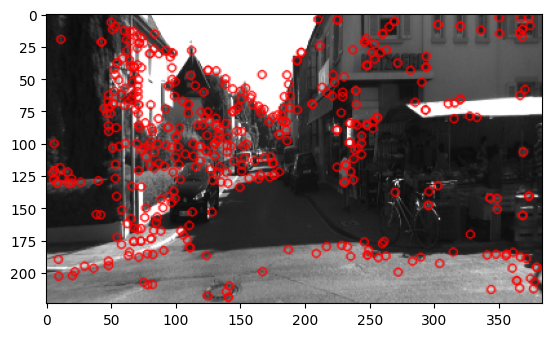

In [72]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

output_image = cv2.drawKeypoints(image1, keypoints1, 0, (255, 0, 0))
plt.imshow(output_image)
plt.show() 

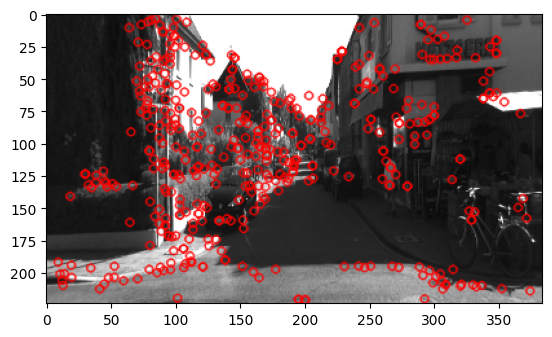

In [73]:
output_image = cv2.drawKeypoints(image2, keypoints2, 0, (255, 0, 0))
plt.imshow(output_image)
plt.show() 

In [74]:
kp1 = []
for point in keypoints1[20:30]:
    kp1.append(point.pt)
# np.asarray(kp1)

In [75]:
kp2 = []
for point in keypoints2[20:30]:
    kp2.append(point.pt)
# np.asarray(kp2)

In [76]:
epilinesL = cv2.computeCorrespondEpilines(np.asarray(kp1).reshape(-1, 1, 2), 1, F = F)
epilinesL = epilinesL.reshape(-1, 3)

In [77]:
epilinesL

array([[-3.99296737e-02,  9.99202493e-01, -1.53656040e+02],
       [-9.68567610e-02,  9.95298331e-01, -1.19186290e+02],
       [-3.96237643e-02,  9.99214670e-01, -1.53839708e+02],
       [-3.17658141e-01,  9.48205308e-01,  2.01812873e+01],
       [-3.17658141e-01,  9.48205308e-01,  2.01812873e+01],
       [-2.17050277e-01,  9.76160426e-01, -4.44745603e+01],
       [-2.10005654e-01,  9.77700171e-01, -4.89276659e+01],
       [-2.30065825e-01,  9.73175070e-01, -3.62221180e+01],
       [-1.90819890e-01,  9.81625066e-01, -6.10078677e+01],
       [ 3.96984697e-02,  9.99211705e-01, -2.00903798e+02]])

In [78]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        print(x0,y0,x1,y1)
        cv2.line(img1, (x0,y0), (x1,y1), color,1)
#         cv2.circle(img1,tuple(pt1), 10, color, -1)
        cv2.circle(img2,tuple(pt2), 10,color,-1)
    return img1,img2

0 153 384 169
0 119 384 157
0 153 384 169
0 -21 384 107
0 -21 384 107
0 45 384 130
0 50 384 132
0 37 384 128
0 62 384 136
0 201 384 185


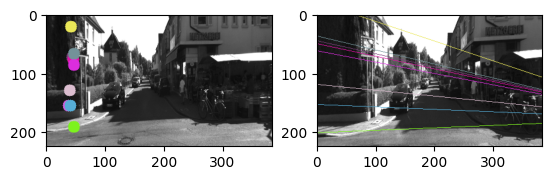

In [79]:
img3,img4 = drawlines(image2,image1,epilinesL,kp2,kp1)
plt.subplot(121),plt.imshow(img4)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [179]:
def find_essential_matrix(img1, img2, K):
    # Convert images to grayscale
#     gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)Screenshot from 2024-02-26 21-11-20
#     gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    gray1 = img1
    gray2 = img2
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # FLANN parameters and matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Filter matches using the Lowe's ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)
# #     Draw the good matches
#     img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good, None, flags=2)
#     plt.imshow(img_matches)
#     plt.axis('off')  # Turn off axis numbers
#     plt.show()
    # Minimum number of matches
    MIN_MATCH_COUNT = 10
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        # Compute the Essential Matrix
        E, mask = cv2.findEssentialMat(src_pts, dst_pts, K)
        return E
    else:
        print(f"Not enough matches are found - {len(good)}/{MIN_MATCH_COUNT}")
        return None

# find the essential matrix
essential_matrix = find_essential_matrix(image1, image2, K)
print("Essential Matrix:\n", essential_matrix)


Essential Matrix:
 [[-2.45498915e-04 -6.05103821e-01 -5.82740555e-02]
 [ 5.94162975e-01 -3.39552015e-03  3.79253851e-01]
 [ 5.47272314e-02 -3.61363599e-01  2.55215450e-04]]


In [6]:
from superpoint import SuperPoint
config = {
        'superpoint': {
            'nms_radius': 4,
            'keypoint_threshold': 0.005,
            'max_keypoints': -1
        }
}

In [7]:
import torch
import torch.nn.functional as F
from torchvision import models

# class KpPostProcess(torch.nn.Module):

#     def __init__(self, grid_size, scale_factor):
#         super(KpPostProcess, self).__init__()
#         self.scale_factor = scale_factor
#         self.grid_size = grid_size

#     def forward(self, features):
#         batch_size, channels, height, width = features.size()
#         # Generate grid indices
#         h_indices = torch.arange(0, height, grid_size)
#         w_indices = torch.arange(0, width, grid_size)
#         h_grid, w_grid = torch.meshgrid(h_indices, w_indices, indexing='ij')
#         grid_indices = torch.stack([h_grid, w_grid], dim=-1).reshape(-1, 2)  # Shape: [num_grids, 2]
#         # Initialize keypoints and descriptors
#         num_grids = grid_indices.shape[0]
#         keypoints = torch.zeros((batch_size, num_grids, 2)).float()
#         keypoints_probs = torch.zeros((batch_size, num_grids, 1)).float()

#         descriptors = torch.zeros((batch_size, num_grids, channels))

#         # Reshape features for batch processing
#         features_reshaped = features.view(batch_size, channels, -1)  # Shape: [batch_size, channels, H*W]

#         # Process each grid cell
#         for i, (h, w) in enumerate(grid_indices):
#             grid = features[:, :, h:h+grid_size, w:w+grid_size]
#             grid_flat = grid.reshape(batch_size, channels, -1)  # Flatten the grid
#             grid_mean = grid_flat.mean(dim=1)  # does this mean taking average of features?

#             # Compute keypoint probabilities and get max indices
#             keypoint_probs = F.softmax(grid_mean, dim=1)
#             max_idxs = keypoint_probs.argmax(dim=1,keepdim=True)
#             # Calculate (x, y) coordinates of keypoints
#             y_coords = (h + max_idxs // grid_size).float() * scale_factor
#             x_coords = (w + max_idxs % grid_size).float() * scale_factor
#             keypoints[:, i, :] = torch.stack([y_coords, x_coords], dim=1)[:,:,0]
#             keypoints_probs[:, i, :] = keypoint_probs.max(dim=1,keepdim=True).values
#             # Extract descriptors
#             row = max_idxs // grid_size
#             col = max_idxs % grid_size
#             descriptors[:,i, :] = grid[:, :, row, col][:, :, 0, 0]

#         return keypoints, descriptors, keypoints_probs

class KpFeatures(torch.nn.Module):

    def __init__(self):#, grid_size, scale_factor):
        super(KpFeatures, self).__init__()
#         # Instantiate ResNet-18 without the final fully connected layer
#         resnet18 = models.resnet18(pretrained=True)
#         self.resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-2])
#         self.deconv1 = torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
#         self.deconv2 = torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
#         self.batch_norm = torch.nn.BatchNorm2d(256)
        self.model = SuperPoint(config)
#         self.post_process = KpPostProcess(grid_size, scale_factor)
    def forward(self, x):
#         # feature extractor
#         x = self.resnet18(x)
#         x = self.deconv1(x)
#         x = self.batch_norm(x)
#         x = self.deconv2(x)
#         # keypoint extraction
#         keypoints, descriptors, keypoints_probs = self.post_process(x)
        x = self.model(x)
#         keypoints, descriptors, keypoints_probs = self.post_process(x['descriptors'])
#         return keypoints, descriptors, keypoints_probs
        return torch.stack(x['keypoints']), torch.transpose(torch.stack(
            x['descriptors']), 1, 2), torch.stack(x['scores']).unsqueeze(dim = 2)


def normalize_keypoints(points, K_inv):
    """
    Normalize keypoints using the inverse camera intrinsic matrix.
    Assumes points are in the shape [batch_size, num_points, 2]
    K_inv is assumed to be [3, 3]
    """
    batch_size, num_points, _ = points.shape

    # Convert to homogeneous coordinates [batch_size, num_points, 3]
    ones = torch.ones(batch_size, num_points, 1, device=points.device)
    homogeneous_points = torch.cat([points, ones], dim=2)

    # Apply K_inv to each point
    # Reshape K_inv to broadcast across the batch
    K_inv_batch = K_inv.unsqueeze(0).repeat(batch_size, 1, 1)

    # Batch matrix multiplication
    normalized_points = torch.bmm(homogeneous_points, K_inv_batch.transpose(1, 2))

    return normalized_points


def sinkhorn_iterations(scores, max_iterations=20, epsilon=1e-3):
    # Apply Sinkhorn iterations for each element in the batch
    for _ in range(max_iterations):
        # Row normalization - ensure normalization is done for each batch separately
        scores = torch.nn.functional.softmax(scores, dim=2)

        # Column normalization - again, separate for each batch
        scores = torch.nn.functional.softmax(scores, dim=1)
    return scores

def contrastive_loss(desc1, desc2, soft_assignment, margin=1.0):
    batch_size, num_points, _ = desc1.shape

    # Calculate the pairwise distance matrix for each batch
    pairwise_distances = torch.cdist(desc1, desc2, p=2)  # Shape: [batch_size, num_points, num_points]

    # Positive pairs: Use soft_assignment as weights for the distances
    positive_loss = torch.sum(soft_assignment * pairwise_distances) / batch_size

    # Negative pairs: Push apart pairs with low assignment probability
    negative_loss = torch.sum((1 - soft_assignment) * torch.clamp(margin - pairwise_distances, min=0)) / batch_size

    loss = positive_loss + 0.5 * negative_loss
    loss = loss/num_points
    return loss

def sampson_distance(points1, points2, E):
    """
    Compute the Sampson distance for batched points and a single Essential Matrix.
    Assumes points1 and points2 are normalized and in homogeneous coordinates,
    with shape [batch_size, total_points, 3].
    E is the Essential Matrix with shape [3, 3].
    """
    # Ensure E is transposed correctly for batch matrix multiplication
    E_transposed = E.transpose(0, 1)  # Should be [3, 3]

    # Apply Essential Matrix to the points
    Fx1 = torch.bmm(points1, E_transposed.unsqueeze(0).repeat(points1.size(0), 1, 1))  # [batch_size, total_points, 3]
    Fx2 = torch.bmm(points2, E.unsqueeze(0).repeat(points2.size(0), 1, 1))             # [batch_size, total_points, 3]

    # Compute the error terms
    errors = (points2 * Fx1).sum(dim=2)  # [batch_size, total_points]

    # Compute the denominator
    denom = Fx1[:, :, 0]**2 + Fx1[:, :, 1]**2 + Fx2[:, :, 0]**2 + Fx2[:, :, 1]**2  # [batch_size, total_points]

    # Compute the Sampson distance
    sampson_dist = (errors**2 / denom).sum(dim=1)  # Sum over points, [batch_size]

    return sampson_dist  # Returns a tensor of shape [batch_size]

![title](Screenshot2024-01-30.png)

In [8]:
descriptor_loss_list = []
geometric_loss_list = []

In [9]:
def ep_loss(desc1, desc2, points1, points2, K, E, alpha, margin=1.0):
    # Descriptor similarity (Euclidean distance as an example)
    desc_distance = torch.cdist(desc1, desc2)
#     print('desc_distance', desc_distance.shape)
    desc_similarity = torch.nn.functional.softmax(-desc_distance, dim=2)
#     print('desc_similarity', desc_similarity.shape)
    soft_assignment = torch.softmax(desc_similarity, dim=1) 
    # size of soft assignment is changing in every epoch because it depends on number of descriptors
    print('soft_assignment', soft_assignment.shape)
    match_indices = torch.argmax(soft_assignment, dim=2)
    
	# Create a range tensor for batch indexing
    batch_indices = torch.arange(points2.size(0)).unsqueeze(1)
    # Use torch.gather to align points2 according to match_indices
    aligned_points2 = torch.gather(points2, 1, match_indices.unsqueeze(-1).expand(-1, -1, points2.size(-1)))
    # Normalize keypoints
    K_inv = torch.inverse(K)  # Inverse of camera intrinsic matrix
    normalized_points1 = normalize_keypoints(points1, K_inv)
    normalized_aligned_points2 = normalize_keypoints(aligned_points2, K_inv)
#     print(normalized_points1.shape, normalized_aligned_points2.shape)
    # Step 3: Calculate Sampson Distance for Geometric Loss
    geometric_loss = sampson_distance(normalized_points1, normalized_aligned_points2, E)

    # Descriptor loss (can be based on soft_assignment)
    descriptor_loss = contrastive_loss(desc1, desc2, soft_assignment, margin=1.0)

    # Combined loss
    descriptor_loss_list.append(descriptor_loss.item())
    geometric_loss_list.append(geometric_loss.item())
    combined_loss = alpha * descriptor_loss + (1 - alpha) * geometric_loss

    return combined_loss

# Function to move tensor to GPU if available
def move_to_gpu(tensor):
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return tensor

# Function to convert a tensor to a numpy array
def tensor_to_numpy(tensor):
    # Move tensor to cpu first if it's on GPU
    if tensor.is_cuda:
        tensor = tensor.cpu()
    return tensor.numpy()


def filter_and_pad_points(prob_tensor, tensor1, tensor2, thresh=0.3, pad_value=0):
    """
    Filters the points in tensor1 and tensor2 across all batches at once based on the
    probability score threshold in prob_tensor, and pads the results to ensure equal size.
    """
#     print('prob_tensor:', prob_tensor.shape)
#     print('tensor1:', tensor1.shape)
#     print('tensor2:', tensor2.shape)
    batch_size, total_points, _ = prob_tensor.shape

    # Initialize lists to store filtered results
    filtered_tensor1_list = []
    filtered_tensor2_list = []

    # Filter each batch separately
    for b in range(batch_size):
        mask = prob_tensor[b, :, 0] > thresh
        filtered_tensor1_list.append(tensor1[b, mask].unsqueeze(0))  # Add a new dimension
        filtered_tensor2_list.append(tensor2[b, mask].unsqueeze(0))  # Add a new dimension

    # Concatenate the filtered results along a new dimension
    concatenated_tensor1 = torch.cat(filtered_tensor1_list, dim=0)
    concatenated_tensor2 = torch.cat(filtered_tensor2_list, dim=0)

    return concatenated_tensor1, concatenated_tensor2

In [10]:
# Define grid size and scale factor
grid_size = 3 # change based on the image encoder
scale_factor = 8 # depends on the image encoder

image1 = (image1.astype('float32') / 255.)
image2 = (image2.astype('float32') / 255.)

# pytorch data preparation
# opencv_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
# opencv_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
opencv_image11 = np.expand_dims(image1, axis = 0)
opencv_image22 = np.expand_dims(image2, axis = 0)
# # Rearrange the axes to [C, H, W]
# opencv_image1 = np.transpose(image1, (2, 0, 1))
# Convert to a float tensor
input1 = torch.unsqueeze(torch.from_numpy(opencv_image11).float(), dim=0)
# input1 = torch.unsqueeze(input1, dim = 0)

# # Rearrange the axes to [C, H, W]
# opencv_image2 = np.transpose(image2, (2, 0, 1))
# Convert to a float tensor
input2 = torch.unsqueeze(torch.from_numpy(opencv_image22).float(), dim=0)
# input2 = torch.unsqueeze(input2, dim = 0)

In [11]:
# kp_net = KpFeatures(grid_size, scale_factor)
kp_net = KpFeatures()
move_to_gpu(kp_net)
learning_rate = 1e-5
optimizer = torch.optim.RMSprop(kp_net.parameters(), lr=learning_rate)

Loaded SuperPoint model


torch.Size([1, 412, 2])
torch.Size([1, 409, 2])


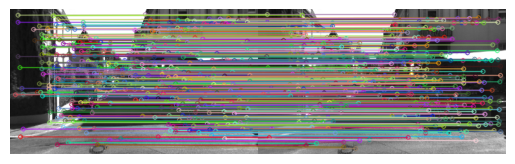

In [12]:
np.array([[391.469, 0, 192],
#               [0, 342.976, 112],
#               [0, 0, 1]])def convert_keypoints(keypoints_array, size=1.0):
    """Converts numpy array keypoints to a list of cv2.KeyPoint objects."""
    return [cv2.KeyPoint(x=float(kp[0]), y=float(kp[1]), size=size) for kp in keypoints_array.reshape(-1, 2)]


kp_net.eval()

with torch.no_grad():
    kp_1, d_1, kp_prob1 = kp_net(move_to_gpu(input1))
    kp_2, d_2, kp_prob2 = kp_net(move_to_gpu(input2))

    
# print(kp_1.shape)
# print(kp_2.shape)

kp_1, d_1 = filter_and_pad_points(kp_prob1, kp_1, d_1, 0)
kp_2, d_2 = filter_and_pad_points(kp_prob2, kp_2, d_2, 0)

print(kp_1.shape)
print(kp_2.shape)

infer_keypoints1 = kp_1.detach().cpu().numpy()
infer_keypoints2 = kp_2.detach().cpu().numpy()

# Convert numpy array keypoints to list of cv2.KeyPoint objects
keypoints1 = convert_keypoints(infer_keypoints1)
keypoints2 = convert_keypoints(infer_keypoints2)

# Create a BFMatcher object
# Choose the appropriate norm type depending on your descriptor
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match( tensor_to_numpy(d_1).reshape(-1, 256), tensor_to_numpy(d_2).reshape(-1, 256))
# print('matches:', matches[0])
# print('keypoints1:', keypoints1)
# print('keypoints2:', keypoints2)
# Apply Lowe's ratio
ratio_threshold = 0.75  # Can be adjusted, common values are in the range 0.7 to 0.8
# good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]
image1 = (image1*255.).astype('uint8')
image2 = (image2*255.).astype('uint8')
# Draw the top N matches
try:
    img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=2)
except:
    print("****************** ERROR DUE TO RANDOM MATCHES: TRY AFTER 10 EPOCHS ********************")

# Display the image
plt.imshow(img_matches)
plt.axis('off')  # Turn off axis numbers
plt.show()


In [13]:
kp_net.train()
for i in range(1):
    for j in range(len(img1_list)-1):
        image1 = img1_list[j]
        image2 = img1_list[j+1]
        img1 = cv2.resize(image1, dim)
        img2 = cv2.resize(image2, dim)
        
        K = np.array([[707.0912, 0, 601.8873],
              [0, 707.0912, 183.1104],
              [0, 0, 1]])        
        essential_matrix = find_essential_matrix(img1, img2, K)
        
        img1 = (img1.astype('float32') / 255.)
        img2 = (img2.astype('float32') / 255.)
        
        opencv_image11 = np.expand_dims(img1, axis = 0)
        opencv_image22 = np.expand_dims(img2, axis = 0)
        
        
        # Convert to a float tensor
        input1 = torch.unsqueeze(torch.from_numpy(opencv_image11).float(), dim=0)
        input2 = torch.unsqueeze(torch.from_numpy(opencv_image22).float(), dim=0)        
        
        keypoints1, des1, kp_prob1 = kp_net(move_to_gpu(input1))
        keypoints2, des2, kp_prob2 = kp_net(move_to_gpu(input2))
        
        
        E = torch.from_numpy(essential_matrix).float()
        K = torch.from_numpy(K).float()
        E = E.cuda()
        K = K.cuda()
        optimizer.zero_grad()
        combined_loss = ep_loss(des1, des2, keypoints1, keypoints2, K, E, alpha = 0.5, margin=1.0)
        if i % 1 == 0:
            print("epoch******", i, combined_loss.item())
        combined_loss.backward()
        optimizer.step()

soft_assignment torch.Size([1, 422, 412])
epoch****** 0 1.044510006904602
soft_assignment torch.Size([1, 424, 406])
epoch****** 0 0.9386193752288818
soft_assignment torch.Size([1, 462, 474])
epoch****** 0 0.9758583903312683
soft_assignment torch.Size([1, 521, 510])
epoch****** 0 0.9344156384468079
soft_assignment torch.Size([1, 538, 557])
epoch****** 0 0.9950242042541504
soft_assignment torch.Size([1, 545, 522])
epoch****** 0 0.9943808317184448
soft_assignment torch.Size([1, 539, 552])
epoch****** 0 0.9786443710327148
soft_assignment torch.Size([1, 498, 494])
epoch****** 0 0.9072507619857788
soft_assignment torch.Size([1, 500, 525])
epoch****** 0 0.9713910818099976
soft_assignment torch.Size([1, 510, 496])
epoch****** 0 0.8896795511245728
soft_assignment torch.Size([1, 529, 523])
epoch****** 0 0.8974589109420776
soft_assignment torch.Size([1, 488, 492])
epoch****** 0 0.9899613857269287
soft_assignment torch.Size([1, 510, 499])
epoch****** 0 0.9265815019607544
soft_assignment torch.Size

soft_assignment torch.Size([1, 455, 494])
epoch****** 0 1.1696802377700806
soft_assignment torch.Size([1, 479, 443])
epoch****** 0 1.0780999660491943
soft_assignment torch.Size([1, 384, 391])
epoch****** 0 0.9774420261383057
soft_assignment torch.Size([1, 416, 475])
epoch****** 0 1.1020337343215942
soft_assignment torch.Size([1, 464, 387])
epoch****** 0 0.8804788589477539
soft_assignment torch.Size([1, 397, 400])
epoch****** 0 0.8945713639259338
soft_assignment torch.Size([1, 446, 426])
epoch****** 0 0.9413884282112122
soft_assignment torch.Size([1, 378, 432])
epoch****** 0 1.0967421531677246
soft_assignment torch.Size([1, 492, 511])
epoch****** 0 1.0194116830825806
soft_assignment torch.Size([1, 431, 441])
epoch****** 0 1.0540310144424438
soft_assignment torch.Size([1, 513, 512])
epoch****** 0 1.0659313201904297
soft_assignment torch.Size([1, 431, 404])
epoch****** 0 0.9785827994346619
soft_assignment torch.Size([1, 392, 384])
epoch****** 0 0.9131945371627808
soft_assignment torch.Siz

soft_assignment torch.Size([1, 179, 128])
epoch****** 0 0.7185520529747009
soft_assignment torch.Size([1, 138, 154])
epoch****** 0 0.8713198900222778
soft_assignment torch.Size([1, 133, 131])
epoch****** 0 0.8019760847091675
soft_assignment torch.Size([1, 160, 156])
epoch****** 0 0.8740072250366211
soft_assignment torch.Size([1, 158, 160])
epoch****** 0 0.8547788858413696
soft_assignment torch.Size([1, 151, 151])
epoch****** 0 0.9138151407241821
soft_assignment torch.Size([1, 140, 155])
epoch****** 0 0.986742377281189
soft_assignment torch.Size([1, 113, 117])
epoch****** 0 0.7874364852905273
soft_assignment torch.Size([1, 124, 131])
epoch****** 0 0.8413846492767334
soft_assignment torch.Size([1, 145, 167])
epoch****** 0 0.9053785800933838
soft_assignment torch.Size([1, 264, 218])
epoch****** 0 0.9954370260238647
soft_assignment torch.Size([1, 209, 219])
epoch****** 0 0.9733877182006836
soft_assignment torch.Size([1, 190, 194])
epoch****** 0 0.8931210041046143
soft_assignment torch.Size

soft_assignment torch.Size([1, 49, 62])
epoch****** 0 0.8772850036621094
soft_assignment torch.Size([1, 60, 76])
epoch****** 0 0.8305990695953369
soft_assignment torch.Size([1, 83, 83])
epoch****** 0 0.7295143604278564
soft_assignment torch.Size([1, 85, 87])
epoch****** 0 0.7437741756439209
soft_assignment torch.Size([1, 87, 91])
epoch****** 0 0.7584748268127441
soft_assignment torch.Size([1, 92, 96])
epoch****** 0 0.7270714044570923
soft_assignment torch.Size([1, 103, 104])
epoch****** 0 0.7088344693183899
soft_assignment torch.Size([1, 110, 141])
epoch****** 0 0.9189966917037964
soft_assignment torch.Size([1, 152, 135])
epoch****** 0 0.7362518310546875
soft_assignment torch.Size([1, 138, 119])
epoch****** 0 0.6481159925460815
soft_assignment torch.Size([1, 127, 144])
epoch****** 0 0.8307948112487793
soft_assignment torch.Size([1, 132, 127])
epoch****** 0 0.7569333910942078
soft_assignment torch.Size([1, 112, 118])
epoch****** 0 0.7877707481384277
soft_assignment torch.Size([1, 112, 1

soft_assignment torch.Size([1, 109, 78])
epoch****** 0 0.5747631788253784
soft_assignment torch.Size([1, 81, 106])
epoch****** 0 0.9079059958457947
soft_assignment torch.Size([1, 116, 97])
epoch****** 0 0.7101333141326904
soft_assignment torch.Size([1, 104, 143])
epoch****** 0 1.0334482192993164
soft_assignment torch.Size([1, 160, 139])
epoch****** 0 0.7691309452056885
soft_assignment torch.Size([1, 139, 120])
epoch****** 0 0.7591556310653687
soft_assignment torch.Size([1, 118, 138])
epoch****** 0 0.8605819940567017
soft_assignment torch.Size([1, 132, 131])
epoch****** 0 0.7641327977180481
soft_assignment torch.Size([1, 121, 113])
epoch****** 0 0.7314202785491943
soft_assignment torch.Size([1, 114, 111])
epoch****** 0 0.8905977010726929
soft_assignment torch.Size([1, 132, 110])
epoch****** 0 0.7919354438781738
soft_assignment torch.Size([1, 108, 109])
epoch****** 0 0.7972743511199951
soft_assignment torch.Size([1, 97, 115])
epoch****** 0 0.892056405544281
soft_assignment torch.Size([1,

soft_assignment torch.Size([1, 124, 139])
epoch****** 0 0.8670169711112976
soft_assignment torch.Size([1, 152, 186])
epoch****** 0 1.0014355182647705
soft_assignment torch.Size([1, 216, 174])
epoch****** 0 0.7295225858688354
soft_assignment torch.Size([1, 168, 195])
epoch****** 0 0.9219930171966553
soft_assignment torch.Size([1, 190, 206])
epoch****** 0 0.9213494062423706
soft_assignment torch.Size([1, 206, 192])
epoch****** 0 0.8400496244430542
soft_assignment torch.Size([1, 191, 192])
epoch****** 0 0.9282630085945129
soft_assignment torch.Size([1, 212, 204])
epoch****** 0 0.9137563109397888
soft_assignment torch.Size([1, 205, 206])
epoch****** 0 0.8869465589523315
soft_assignment torch.Size([1, 175, 179])
epoch****** 0 0.8755728006362915
soft_assignment torch.Size([1, 162, 187])
epoch****** 0 0.9448494911193848
soft_assignment torch.Size([1, 178, 150])
epoch****** 0 0.732733964920044
soft_assignment torch.Size([1, 149, 137])
epoch****** 0 0.8228178024291992
soft_assignment torch.Size

soft_assignment torch.Size([1, 85, 84])
epoch****** 0 0.771129846572876
soft_assignment torch.Size([1, 88, 67])
epoch****** 0 0.7484910488128662
soft_assignment torch.Size([1, 65, 70])
epoch****** 0 0.7594280242919922
soft_assignment torch.Size([1, 66, 71])
epoch****** 0 0.8752882480621338
soft_assignment torch.Size([1, 69, 61])
epoch****** 0 0.6772454380989075
soft_assignment torch.Size([1, 85, 101])
epoch****** 0 0.9651492238044739
soft_assignment torch.Size([1, 97, 100])
epoch****** 0 0.7956284284591675
soft_assignment torch.Size([1, 97, 98])
epoch****** 0 0.7876905798912048
soft_assignment torch.Size([1, 103, 103])
epoch****** 0 0.7915337085723877
soft_assignment torch.Size([1, 106, 134])
epoch****** 0 0.9527239203453064
soft_assignment torch.Size([1, 109, 109])
epoch****** 0 0.7548084855079651
soft_assignment torch.Size([1, 86, 90])
epoch****** 0 0.7774345874786377
soft_assignment torch.Size([1, 103, 83])
epoch****** 0 0.6435530781745911
soft_assignment torch.Size([1, 86, 96])
epo

soft_assignment torch.Size([1, 51, 68])
epoch****** 0 0.8928400278091431
soft_assignment torch.Size([1, 76, 81])
epoch****** 0 0.7531629204750061
soft_assignment torch.Size([1, 82, 47])
epoch****** 0 0.4962003827095032
soft_assignment torch.Size([1, 47, 65])
epoch****** 0 0.8934932947158813
soft_assignment torch.Size([1, 47, 46])
epoch****** 0 0.6786491870880127
soft_assignment torch.Size([1, 53, 53])
epoch****** 0 0.755496621131897
soft_assignment torch.Size([1, 50, 50])
epoch****** 0 0.7017666697502136
soft_assignment torch.Size([1, 46, 32])
epoch****** 0 0.4832935929298401
soft_assignment torch.Size([1, 30, 63])
epoch****** 0 1.2746251821517944
soft_assignment torch.Size([1, 58, 45])
epoch****** 0 0.5704954862594604
soft_assignment torch.Size([1, 67, 63])
epoch****** 0 0.6704038381576538
soft_assignment torch.Size([1, 53, 56])
epoch****** 0 0.7548940181732178
soft_assignment torch.Size([1, 54, 62])
epoch****** 0 0.7796465754508972
soft_assignment torch.Size([1, 76, 49])
epoch****** 

soft_assignment torch.Size([1, 50, 46])
epoch****** 0 0.59322589635849
soft_assignment torch.Size([1, 40, 51])
epoch****** 0 0.8002007007598877
soft_assignment torch.Size([1, 60, 55])
epoch****** 0 0.6359058618545532
soft_assignment torch.Size([1, 50, 51])
epoch****** 0 0.6804631948471069
soft_assignment torch.Size([1, 60, 76])
epoch****** 0 0.8706768751144409
soft_assignment torch.Size([1, 76, 76])
epoch****** 0 0.7082451581954956
soft_assignment torch.Size([1, 83, 82])
epoch****** 0 0.713064968585968
soft_assignment torch.Size([1, 57, 55])
epoch****** 0 0.6676152944564819
soft_assignment torch.Size([1, 59, 58])
epoch****** 0 0.6696144938468933
soft_assignment torch.Size([1, 66, 58])
epoch****** 0 0.6043146848678589
soft_assignment torch.Size([1, 49, 41])
epoch****** 0 0.5728887915611267
soft_assignment torch.Size([1, 44, 46])
epoch****** 0 0.6759880781173706
soft_assignment torch.Size([1, 49, 69])
epoch****** 0 0.9193027019500732
soft_assignment torch.Size([1, 58, 71])
epoch****** 0 

soft_assignment torch.Size([1, 75, 66])
epoch****** 0 0.6624025106430054
soft_assignment torch.Size([1, 65, 77])
epoch****** 0 0.842326283454895
soft_assignment torch.Size([1, 86, 66])
epoch****** 0 0.6324676871299744
soft_assignment torch.Size([1, 67, 90])
epoch****** 0 0.91832435131073
soft_assignment torch.Size([1, 97, 55])
epoch****** 0 0.51172935962677
soft_assignment torch.Size([1, 55, 91])
epoch****** 0 1.0766997337341309
soft_assignment torch.Size([1, 87, 76])
epoch****** 0 0.6589678525924683
soft_assignment torch.Size([1, 80, 71])
epoch****** 0 0.673623263835907
soft_assignment torch.Size([1, 73, 63])
epoch****** 0 0.6282953023910522
soft_assignment torch.Size([1, 64, 91])
epoch****** 0 0.9583339691162109
soft_assignment torch.Size([1, 80, 88])
epoch****** 0 0.7896996736526489
soft_assignment torch.Size([1, 77, 78])
epoch****** 0 0.6994554996490479
soft_assignment torch.Size([1, 77, 37])
epoch****** 0 0.40437981486320496
soft_assignment torch.Size([1, 34, 36])
epoch****** 0 0.

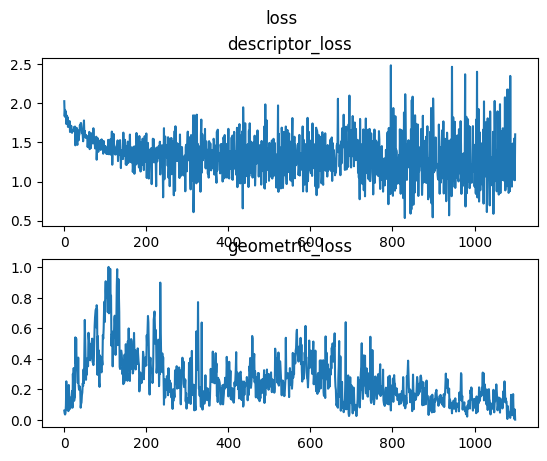

In [14]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('loss')
ax1.set_title('descriptor_loss')
ax2.set_title('geometric_loss')
ax1.plot(descriptor_loss_list)
ax2.plot(geometric_loss_list)

In [15]:
image1 = img1_list[0]
image2 = img1_list[1]
img1 = cv2.resize(image1, dim)
img2 = cv2.resize(image2, dim)
        
img1 = (img1.astype('float32') / 255.)
img2 = (img2.astype('float32') / 255.)
        
opencv_image11 = np.expand_dims(img1, axis = 0)
opencv_image22 = np.expand_dims(img2, axis = 0)

# Convert to a float tensor
input1 = torch.unsqueeze(torch.from_numpy(opencv_image11).float(), dim=0)
input2 = torch.unsqueeze(torch.from_numpy(opencv_image22).float(), dim=0) 

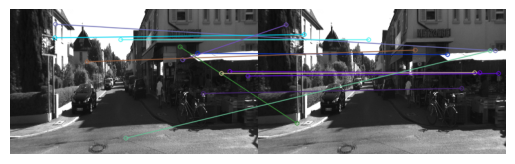

In [16]:
kp_net.eval()

with torch.no_grad():
    kp_1, d_1, kp_prob1 = kp_net(move_to_gpu(input1))
    kp_2, d_2, kp_prob2 = kp_net(move_to_gpu(input2))

kp_1, d_1 = filter_and_pad_points(kp_prob1, kp_1, d_1, 0.005)
kp_2, d_2 = filter_and_pad_points(kp_prob2, kp_2, d_2, 0.005)

infer_keypoints1 = kp_1.detach().cpu().numpy()
infer_keypoints2 = kp_2.detach().cpu().numpy()


def convert_keypoints(keypoints_array, size=1.0):
    """Converts numpy array keypoints to a list of cv2.KeyPoint objects."""
    return [cv2.KeyPoint(x=float(kp[0]), y=float(kp[1]), size=size) for kp in keypoints_array.reshape(-1, 2)]

# Convert numpy array keypoints to list of cv2.KeyPoint objects
keypoints1 = convert_keypoints(infer_keypoints1)
keypoints2 = convert_keypoints(infer_keypoints2)

# Create a BFMatcher object
# Choose the appropriate norm type depending on your descriptor
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match( tensor_to_numpy(d_1).reshape(-1, 256), tensor_to_numpy(d_2).reshape(-1, 256))

# Apply Lowe's ratio test
ratio_threshold = 0.75  # Can be adjusted, common values are in the range 0.7 to 0.8
# good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]
img1 = (img1*255).astype('uint8')
img2 = (img2*255).astype('uint8')
# Draw the top N matches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, flags=2)

# Display the result
# Display the image
plt.imshow(img_matches)
plt.axis('off')  # Turn off axis numbers
plt.show()
